# **Spectral Index Evaluation of Land Use Compliance with the PBOT in La Ceja**
This project aims to analyze and quantify the urban expansion in La Ceja, a municipality located in Eastern Antioquia (Colombia), between the years 2018 and 2025. Using Sentinel-2 multispectral satellite imagery, we calculate spectral indices such as NDVI (Normalized Difference Vegetation Index) and NDBI (Normalized Difference Built-up Index) to detect changes in vegetation cover and built-up areas.

These spatial transformations are then compared with the urban growth zones defined in the Municipal Land Use Plan (PBOT) established by Agreement 001 of 2018. The overlay between remote sensing analysis and official planning boundaries allows us to assess whether recent urban development has occurred within legally designated areas or has exceeded regulated expansion zones.

This approach provides technical evidence to support sustainable territorial management, monitor compliance with planning regulations, and inform future decision-making by local authorities. The project also explores the effectiveness of remote sensing as a tool for land-use monitoring in rapidly growing intermediate municipalities.


## Libraries and necessary packs

In [46]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import seaborn as sns
import geopandas as gpd
from pathlib import Path
import glob
import os
from tqdm import tqdm
from IPython.display import display
import re

## Upload and stack verification

Code to verify the content of archives ".tif", it makes the band decomposition, index and description of each one

In [47]:
import rasterio
import os

stack_dir = "./carpeta_stacks" # Stacks directory
for filename in os.listdir(stack_dir):
    if filename.endswith(".tif"):
        file_path = os.path.join(stack_dir, filename)
        with rasterio.open(file_path) as src_file:
            print(f"File: {filename}")
            print("Number of bands:", src_file.count)
            print("Available index from bands:", src_file.indexes)
            desc = src_file.descriptions
            if desc is None:
                print("No descriptions available.")
            else:
                for idx, d in enumerate(desc, start=1):
                    print(f"Band {idx}: {d}")
            print("-" * 40) # Separator for clarity


File: 2018-08-07_stack3.tif
Number of bands: 3
Available index from bands: (1, 2, 3)
Band 1: NDVI
Band 2: NDBI
Band 3: UI
----------------------------------------
File: 2019-01-04_stack3.tif
Number of bands: 3
Available index from bands: (1, 2, 3)
Band 1: NDVI
Band 2: NDBI
Band 3: UI
----------------------------------------
File: 2019-07-18_stack3.tif
Number of bands: 3
Available index from bands: (1, 2, 3)
Band 1: NDVI
Band 2: NDBI
Band 3: UI
----------------------------------------
File: 2019-08-27_stack3.tif
Number of bands: 3
Available index from bands: (1, 2, 3)
Band 1: NDVI
Band 2: NDBI
Band 3: UI
----------------------------------------
File: 2020-01-09_stack3.tif
Number of bands: 3
Available index from bands: (1, 2, 3)
Band 1: NDVI
Band 2: NDBI
Band 3: UI
----------------------------------------
File: 2020-02-18_stack3.tif
Number of bands: 3
Available index from bands: (1, 2, 3)
Band 1: NDVI
Band 2: NDBI
Band 3: UI
----------------------------------------
File: 2023-08-26_stack

Esta sección recorre de forma automática todos los “stacks” multibanda y extrae los valores de índice en cada punto de muestreo, construyendo un único DataFrame (`df_all`) con toda la información. En concreto:

**Cargar GeoPackage**  
   Lee todas las capas de puntos almacenadas en `muestras_training.gpkg`. Cada capa se llama `pts_YYYY-MM-DD`, de modo que existe una capa distinta para cada fecha de muestreo.

**Listar rásteres**  
   Utiliza `glob` para localizar todos los archivos GeoTIFF que sigan el patrón `*_stack3.tif` dentro de la carpeta de “stacks”.

 **Extraer fecha**  
   Para cada archivo ráster, extrae la fecha (`YYYY-MM-DD`) del nombre de fichero mediante una expresión regular, de forma que luego podamos emparejarlo con la capa `pts_<fecha>` correspondiente.

**Muestrear índices**  
   Abre cada ráster con Rasterio y, tomando las coordenadas de cada punto de la capa `pts_<fecha>`, extrae los valores de las tres bandas:  
   - `NDVI`  
   - `NDBI`  
   - `UI`

**Construir registros**  
   Para cada fecha, crea un DataFrame parcial con las columnas:  
   - `raster_date`: fecha extraída del nombre del archivo  
   - `point_date` : fecha original que figura en la capa de puntos  
   - `label`      : clase o etiqueta asociada a cada punto  
   - `x`, `y`     : coordenadas de cada punto  
   - `NDVI`, `NDBI`, `UI`: valores muestreados en esas coordenadas

**Concatenar todo**  
   Combina todos los DataFrames parciales en uno solo (`df_all`), reiniciando el índice para tener un índice continuo.

**Verificar resultados**  
   Muestra por consola:  
   - El número total de muestras (`df_all.shape[0]`)  
   - La lista de columnas (`df_all.columns.tolist()`)  
   - Las primeras filas de `df_all.head(10)` para asegurarse de que los datos se han cargado y muestreado correctamente.  

In [48]:
# Ruta al geopackage y patrón de archivos raster
gpkg_path      = './carpeta_stacks/muestras_training.gpkg'
stacks_pattern = './carpeta_stacks/*_stack3.tif'   # asegurarnos de que coincida con *_stack3.tif

# Listar capas disponibles en el GPKG, para verificar nombres
from fiona import listlayers
print("Capas en el GPKG:", listlayers(gpkg_path))

# Listar archivos raster
raster_files = sorted(glob.glob(stacks_pattern))
print(f"Found {len(raster_files)} raster stacks:")
for rf in raster_files:
    print(" •", rf)

# Muestrear cada stack y construir registros
records = []
for rf in tqdm(raster_files, desc="Sampling stacks"):
    # Extraer solo la fecha con regex: busca 4 dígitos-2 dígitos-2 dígitos
    filename = os.path.basename(rf)
    m = re.match(r'(\d{4}-\d{2}-\d{2})', filename)
    if not m:
        print(f"  ¡No pude extraer fecha de '{filename}', salto este archivo.")
        continue
    date_str = m.group(1)
    
    pts_layer = f"pts_{date_str}"
    print(f"\n→ Processing date {date_str}, layer '{pts_layer}'")
    
    # Leer la capa de puntos correspondiente
    try:
        gdf_pts = gpd.read_file(gpkg_path, layer=pts_layer)
    except Exception as e:
        print(f"  Error al leer la capa {pts_layer}: {e}")
        continue
    
    coords = [(pt.x, pt.y) for pt in gdf_pts.geometry]
    
    # Muestrear bandas NDVI, NDBI, UI
    with rasterio.open(rf) as src:
        samples = list(src.sample(coords))
    
    # Construir DataFrame de este día
    df = pd.DataFrame(samples, columns=['NDVI','NDBI','UI'])
    df['raster_date'] = date_str
    df['point_date']  = gdf_pts['date']
    df['label']       = gdf_pts['label']
    df['x']           = gdf_pts.geometry.x
    df['y']           = gdf_pts.geometry.y
    
    records.append(df)

# Concatenar todo en un solo DataFrame
if records:
    df_all = pd.concat(records, ignore_index=True)
    print("\nAll samples collected:", df_all.shape[0])
    print("Columns:", df_all.columns.tolist())
    print(df_all.head(10))
else:
    print("No se obtuvo ningún registro.")

Capas en el GPKG: ['poly_2018-08-07', 'poly_2019-01-04', 'poly_2019-07-18', 'poly_2019-08-27', 'poly_2020-01-09', 'poly_2020-02-18', 'poly_2023-08-26', 'poly_2024-01-23', 'poly_2024-06-01', 'poly_2024-08-15', 'pts_2018-08-07', 'pts_2019-01-04', 'pts_2019-07-18', 'pts_2019-08-27', 'pts_2020-01-09', 'pts_2020-02-18', 'pts_2023-08-26', 'pts_2024-01-23', 'pts_2024-06-01', 'pts_2024-08-15']
Found 10 raster stacks:
 • ./carpeta_stacks\2018-08-07_stack3.tif
 • ./carpeta_stacks\2019-01-04_stack3.tif
 • ./carpeta_stacks\2019-07-18_stack3.tif
 • ./carpeta_stacks\2019-08-27_stack3.tif
 • ./carpeta_stacks\2020-01-09_stack3.tif
 • ./carpeta_stacks\2020-02-18_stack3.tif
 • ./carpeta_stacks\2023-08-26_stack3.tif
 • ./carpeta_stacks\2024-01-23_stack3.tif
 • ./carpeta_stacks\2024-06-01_stack3.tif
 • ./carpeta_stacks\2024-08-15_stack3.tif


Sampling stacks:   0%|          | 0/10 [00:00<?, ?it/s]


→ Processing date 2018-08-07, layer 'pts_2018-08-07'


Sampling stacks:  10%|█         | 1/10 [00:00<00:03,  2.48it/s]


→ Processing date 2019-01-04, layer 'pts_2019-01-04'


Sampling stacks:  20%|██        | 2/10 [00:00<00:02,  3.32it/s]


→ Processing date 2019-07-18, layer 'pts_2019-07-18'


Sampling stacks:  30%|███       | 3/10 [00:00<00:01,  3.70it/s]


→ Processing date 2019-08-27, layer 'pts_2019-08-27'


Sampling stacks:  40%|████      | 4/10 [00:01<00:01,  3.65it/s]


→ Processing date 2020-01-09, layer 'pts_2020-01-09'


Sampling stacks:  50%|█████     | 5/10 [00:01<00:01,  3.57it/s]


→ Processing date 2020-02-18, layer 'pts_2020-02-18'


Sampling stacks:  60%|██████    | 6/10 [00:01<00:01,  3.66it/s]


→ Processing date 2023-08-26, layer 'pts_2023-08-26'


Sampling stacks:  70%|███████   | 7/10 [00:01<00:00,  3.81it/s]


→ Processing date 2024-01-23, layer 'pts_2024-01-23'


Sampling stacks:  80%|████████  | 8/10 [00:02<00:00,  3.85it/s]


→ Processing date 2024-06-01, layer 'pts_2024-06-01'


Sampling stacks:  90%|█████████ | 9/10 [00:02<00:00,  3.74it/s]


→ Processing date 2024-08-15, layer 'pts_2024-08-15'


Sampling stacks: 100%|██████████| 10/10 [00:02<00:00,  3.67it/s]


All samples collected: 20000
Columns: ['NDVI', 'NDBI', 'UI', 'raster_date', 'point_date', 'label', 'x', 'y']
       NDVI      NDBI   UI raster_date  point_date  label          x         y
0  0.786443 -0.266387 -1.0  2018-08-07  2018-08-07      0 -75.457590  6.034681
1  0.699720 -0.191894 -1.0  2018-08-07  2018-08-07      0 -75.457657  6.035646
2  0.695204 -0.225916 -1.0  2018-08-07  2018-08-07      0 -75.454943  6.035268
3  0.676704 -0.233593 -1.0  2018-08-07  2018-08-07      0 -75.454789  6.035266
4  0.708695 -0.221719 -1.0  2018-08-07  2018-08-07      0 -75.456248  6.034848
5  0.652954 -0.159419 -1.0  2018-08-07  2018-08-07      0 -75.457122  6.035479
6  0.635360 -0.155753 -1.0  2018-08-07  2018-08-07      0 -75.455515  6.034363
7  0.763023 -0.231868 -1.0  2018-08-07  2018-08-07      0 -75.457403  6.034237
8  0.647756 -0.157061 -1.0  2018-08-07  2018-08-07      0 -75.454026  6.035202
9  0.705901 -0.191030 -1.0  2018-08-07  2018-08-07      0 -75.457640  6.035178


### Save DataFrame for out inspection

In [ ]:
output_xlsx  = './carpeta_stacks/df_all_samples.xlsx' # Cambiar a la ruta deseada
df_all.to_excel(output_xlsx, index=False)
print(f"DataFrame exportado a Excel en: {output_xlsx}")

DataFrame exportado a Excel en: ./carpeta_stacks/df_all_samples.xlsx


Esta sección prepara las muestras crudas para el entrenamiento del modelo mediante:

**Alineación temporal**  
   - Convertir `raster_date` y `point_date` a tipo `datetime`.  
   - Filtrar para conservar únicamente los registros cuya fecha de ráster coincide exactamente con la fecha de muestreo del punto.  
   - Resultado: una muestra por punto en el día de adquisición correcto.

**Manejo de valores faltantes**  
   - Detectar cualquier `NaN` en las columnas `NDVI`, `NDBI` o `UI` (por ejemplo, debido a cobertura nubosa).  
   - Eliminar las muestras que contengan valores faltantes.

**Verificación de distribución**  
   - Generar diagramas de caja (boxplots) de cada índice (`NDVI`, `NDBI`, `UI`) agrupados por etiqueta de clase.  
   - Visualizar solapamientos o separaciones entre clases como comprobación previa al entrenamiento.


In [54]:
# Convertir las fechas a tipo datetime
df_all['raster_date'] = pd.to_datetime(df_all['raster_date'], format='%Y-%m-%d')
df_all['point_date']  = pd.to_datetime(df_all['point_date'])

# Filtrar registros donde las fechas coinciden
df_matched = df_all[
    df_all['raster_date'] == df_all['point_date']
].copy()

# Mostrar resultados
print("Total de registros en df_all:   ", df_all.shape[0])
print("Registros con fecha coincidente:", df_matched.shape[0])
df_matched.head(10)

Total de registros en df_all:    20000
Registros con fecha coincidente: 20000


,NDVI,NDBI,UI,raster_date,point_date,label,x,y
0,0.786443,-0.266387,-1.0,2018-08-07,2018-08-07,0,-75.457590,6.034681
1,0.699720,-0.191894,-1.0,2018-08-07,2018-08-07,0,-75.457657,6.035646
2,0.695204,-0.225916,-1.0,2018-08-07,2018-08-07,0,-75.454943,6.035268
3,0.676704,-0.233593,-1.0,2018-08-07,2018-08-07,0,-75.454789,6.035266
4,0.708695,-0.221719,-1.0,2018-08-07,2018-08-07,0,-75.456248,6.034848
5,0.652954,-0.159419,-1.0,2018-08-07,2018-08-07,0,-75.457122,6.035479
6,0.635360,-0.155753,-1.0,2018-08-07,2018-08-07,0,-75.455515,6.034363
7,0.763023,-0.231868,-1.0,2018-08-07,2018-08-07,0,-75.457403,6.034237
8,0.647756,-0.157061,-1.0,2018-08-07,2018-08-07,0,-75.454026,6.035202
9,0.705901,-0.191030,-1.0,2018-08-07,2018-08-07,0,-75.457640,6.035178


In [55]:
# Verificar valores faltantes
print("Valores faltantes por columna:\n", df_matched.isna().sum())
df_clean = df_matched.dropna(subset=['NDVI','NDBI','UI'])
print("Registros después de eliminar NaN en NDVI, NDBI o UI:", df_clean.shape[0])

Valores faltantes por columna:
 NDVI           0
NDBI           0
UI             0
raster_date    0
point_date     0
label          0
x              0
y              0
dtype: int64
Registros después de eliminar NaN en NDVI, NDBI o UI: 20000


<Figure size 640x480 with 0 Axes>

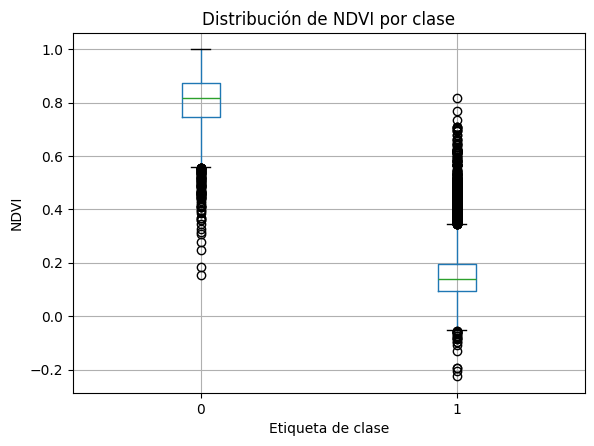

<Figure size 640x480 with 0 Axes>

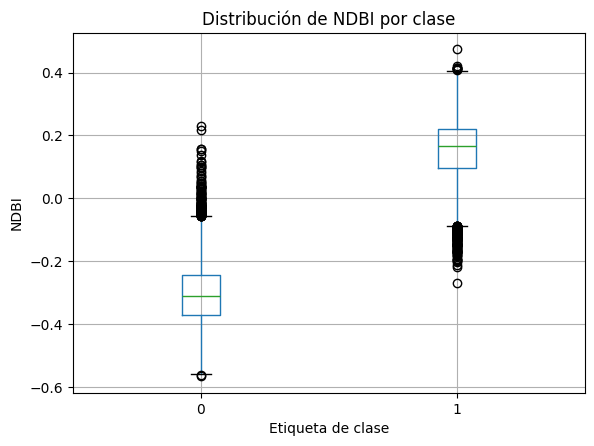

<Figure size 640x480 with 0 Axes>

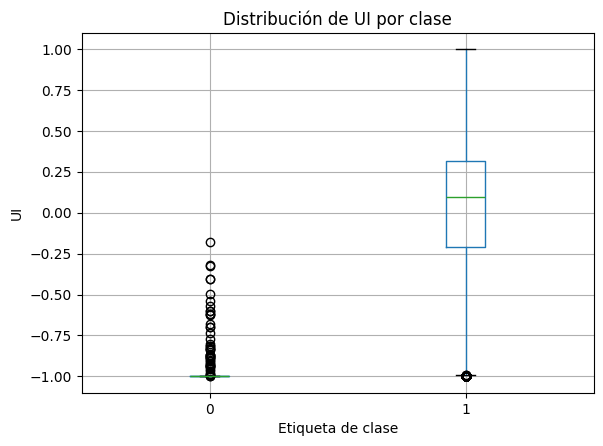

In [56]:
for idx in ['NDVI', 'NDBI', 'UI']:
    plt.figure()
    df_clean.boxplot(column=idx, by='label')
    plt.title(f'Distribución de {idx} por clase')
    plt.suptitle('')
    plt.xlabel('Etiqueta de clase')
    plt.ylabel(idx)
    plt.show()

## Análisis de distribuciones por boxplot e índice

A continuación se interpreta cada caja de distribución en función de la clase (0 vs. 1) y la lógica espectral de los índices.

---

### 1. NDVI (Índice de Vegetación de Diferencia Normalizada)

- **Clase 0**  
  - **Mediana alta (~0,82)** y **IQR** estrecho (≈0,75–0,88): refleja vegetación densa y saludable, que devuelve alta radiancia en el infrarrojo cercano y absorbe en rojo.  
  - **Rango superior** llega hasta ~1,0 (valores máximos teóricos de NDVI) y **outliers** inferiores (~0,15–0,40) pueden corresponder a puntos con vegetación escasa o sombra.  
- **Clase 1**  
  - **Mediana baja (~0,15)** y IQR en torno a 0,10–0,20: caracteriza áreas no vegetadas (suelo desnudo, áreas urbanas), donde la firma de infrarrojo cercano es baja.  
  - Presencia de **outliers negativos** (hasta ~–0,20) sugiere superficies de agua o muy poca vegetación.  

> **Conclusión**: la separación neta entre medianas y rangos hace que NDVI sea muy discriminante entre vegetación (clase 0) y no-vegetación (clase 1).

---

### 2. NDBI (Índice de Construcción Normalizada)

- **Clase 0**  
  - **Mediana negativa (~–0,30)** y IQR ≈–0,35 a –0,25: coincide con vegetación y suelo desnudo que devuelven más reflectancia en SWIR que en NIR (valores negativos de NDBI).  
  - **Outliers** positivos aislados (~0,10–0,20) pueden deberse a suelos claros o materiales reflectantes temporales.  
- **Clase 1**  
  - **Mediana positiva (~0,18)** y IQR entre ~0,10 y 0,22: típico de áreas urbanas o construidas, donde la reflectancia SWIR es menor frente a NIR.  
  - **Outliers altos** (~0,30–0,50) indican superficies muy reflectivas (techos, carreteras amplias).  

> **Conclusión**: NDBI invierte la lógica del NDVI y discrimina bien construcciones (clase 1) con valores positivos, frente a vegetación/suelos (clase 0) con valores negativos.

---

### 3. UI (Urban Index)

- **Clase 0**  
  - **Mediana cercana a –1,0** y IQR muy estrecho alrededor de ese valor: representa zonas claramente no urbanas (vegetación densa o agua), donde UI tiende a su límite negativo.  
  - **Outliers** por encima de –0,8 pueden corresponder a pequeñas infraestructuras aisladas o caminos rurales.  
- **Clase 1**  
  - **Mediana cercana a 0,1** y IQR amplio (≈–0,2 a 0,4): refleja diversidad de superficies urbanas (techos, asfalto, hormigón).  
  - **Rango superior** llega hasta ~1,0 (maximiza la respuesta urbana), y **outliers inferiores** (hasta –1,0) podrían ser puntos vacíos o ruido en la máscara urbana.  

> **Conclusión**: UI concentra los valores extremos para vegetación/agua (cerca de –1) y dispersa los valores urbanos entre –0,2 y 1, lo cual encaja con su definición de realzar píxeles construidos.

---

**Resumen general**  
Los tres índices muestran distribuciones que coinciden con sus principios espectrales:  
- **NDVI** alto en vegetación, bajo en áreas no vegetadas.  
- **NDBI** positivo en construcciones, negativo en vegetación/suelo.  
- **UI** minimalista para ambiente natural y disperso para entorno urbano.  

Esta separación clara respalda su uso conjunto para clasificar coberturas de suelo en entornos mixtos.  


### División temporal Entrenamiento/Validación

Este bloque segmenta el conjunto de datos según la fecha de adquisición, garantizando que el modelo se entrene con las primeras 7 escenas y se valide con las 3 últimas, evitando así filtrado temporal:

**Fechas únicas**  
   - Obtiene y ordena todas las fechas de escena de `df_clean`.  
**Definir partición**  
   - `train_dates`: primeras 7 fechas.  
   - `val_dates`  : últimas 3 fechas.  
**Subconjuntos**  
   - `df_train` y `df_val` con las muestras correspondientes a esas fechas.  
**Separar características y etiquetas**  
   - `X_train`, `y_train`, `X_val`, `y_val`.  
**Verificación**  
   - Tamaño de cada partición y balance de clases.  


In [57]:
# 1) Fechas únicas ordenadas
unique_dates = sorted(df_clean['raster_date'].unique())

# 2) Definir fechas de entrenamiento (primeras 7) y validación (últimas 3)
train_dates = unique_dates[:7]
val_dates   = unique_dates[7:]

# 3) Crear los DataFrames de train y validation
df_train = df_clean[df_clean['raster_date'].isin(train_dates)].copy()
df_val   = df_clean[df_clean['raster_date'].isin(val_dates)].copy()

# 4) Extraer características y etiquetas
features = ['NDVI', 'NDBI', 'UI']
X_train, y_train = df_train[features], df_train['label']
X_val,   y_val   = df_val[features],   df_val['label']

# 5) Ver tamaños y balance de clases
print(f"Train set: {X_train.shape[0]} muestras de fechas {train_dates}")
print(f"Val   set: {X_val.shape[0]} muestras de fechas {val_dates}\n")

print("Conteo de clases en Train:\n", y_train.value_counts())
print("\nConteo de clases en Val:\n",   y_val.value_counts())


Train set: 14000 muestras de fechas [Timestamp('2018-08-07 00:00:00'), Timestamp('2019-01-04 00:00:00'), Timestamp('2019-07-18 00:00:00'), Timestamp('2019-08-27 00:00:00'), Timestamp('2020-01-09 00:00:00'), Timestamp('2020-02-18 00:00:00'), Timestamp('2023-08-26 00:00:00')]
Val   set: 6000 muestras de fechas [Timestamp('2024-01-23 00:00:00'), Timestamp('2024-06-01 00:00:00'), Timestamp('2024-08-15 00:00:00')]

Conteo de clases en Train:
 label
0    7000
1    7000
Name: count, dtype: int64

Conteo de clases en Val:
 label
0    3000
1    3000
Name: count, dtype: int64


### Model Training and Evaluation

Entrenamos un clasificador **Random Forest** sobre los datos de entrenamiento (primeras 7 fechas) y evaluamos su rendimiento en el conjunto de validación (últimas 3 fechas).

**¿Por qué usar Random Forest?**  
- **Robustez**: combina múltiples árboles de decisión para reducir el sobreajuste y aguantar bien ruido y outliers.  
- **No linealidad**: captura relaciones complejas entre `NDVI`, `NDBI` y `UI` sin necesidad de transformar las variables.  
- **Poco preprocesamiento**: no requiere escalado ni normalización de las características.  
- **Importancia de variables**: facilita saber qué índices aportan más a la clasificación (feature importance).  
- **Paralelización**: puede entrenar muchos árboles en paralelo (usando `n_jobs=-1`) para aprovechar todos los núcleos de CPU.

In [60]:
# Libraries for model training and evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [61]:
# 1) Initialize the Random Forest classifier
#    - 100 árboles, profundidad ilimitada (se dejan crecer completamente)
#    - random_state para reproducibilidad
#    - n_jobs=-1 para usar todos los núcleos de CPU
clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

# 2) Fit the model on the training data
#    X_train: features ['NDVI','NDBI','UI']
#    y_train: labels (0 o 1)
clf.fit(X_train, y_train)
print("Model training complete.")

# 3) Make predictions on the validation set
y_pred = clf.predict(X_val)
print("Predictions on validation set generated.")

# 4) Compute accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.3f}")

# 5) Display confusion matrix
cm = confusion_matrix(y_val, y_pred)
print("\nConfusion Matrix:")
print(cm)

# 6) Show full classification report (precision, recall, f1-score)
report = classification_report(y_val, y_pred)
print("\nClassification Report:")
print(report)

Model training complete.
Predictions on validation set generated.
Validation Accuracy: 0.980

Confusion Matrix:
[[2905   95]
 [  26 2974]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3000
           1       0.97      0.99      0.98      3000

    accuracy                           0.98      6000
   macro avg       0.98      0.98      0.98      6000
weighted avg       0.98      0.98      0.98      6000



##  Resumen de resultados y definición de métricas

A continuación explicamos cada uno de los números obtenidos y el significado de las métricas:

---

### 1. Accuracy (Exactitud global)
- **Valor**: `0.980`  
- **Definición**: proporción de predicciones correctas sobre el total de muestras.  
- **True positives**: Son los casos en que el modelo predice positiva una instancia y realmente pertenece a la clase positiva.
- **True negatives**: Son los casos en que el modelo predice negativa una instancia y realmente pertenece a la clase negativa.
- **Cálculo**:  
  $$
    \text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{Total}}
    = \frac{2974 + 2905}{6000} = 0.98
  $$ 
  donde  
  - TP (True Positives) = 2974  
  - TN (True Negatives) = 2905  
  - Total = 6000 muestras  

---

### 2. Matriz de confusión

|                 | Predicción = 0 | Predicción = 1 |
|:---------------:|:--------------:|:--------------:|
| **Real = 0**    | TN = 2905      | FP = 95        |
| **Real = 1**    | FN = 26        | TP = 2974      |

- **TN (True Negative)**: puntos de clase 0 correctamente clasificados (2905).  
- **FP (False Positive)**: puntos de clase 0 mal clasificados como clase 1 (95). Son los casos en que el modelo predice positiva una instancia, pero en realidad pertenece a la clase 
- **FN (False Negative)**: puntos de clase 1 mal clasificados como clase 0 (26). Son los casos en que el modelo predice negativa una instancia, pero en realidad pertenece a la clase positiva.
- **TP (True Positive)**: puntos de clase 1 correctamente clasificados (2974).  

---

### 3. Métricas por clase

Para cada etiqueta (0 = vegetación, 1 = urbano) se calculan:

| Clase | Precision | Recall  | F1-score | Support |
|:-----:|:---------:|:-------:|:--------:|:-------:|
|   0   |   0.99    |  0.97   |   0.98   |  3000   |
|   1   |   0.97    |  0.99   |   0.98   |  3000   |

- **Precision**  
  $$
    \text{Precision}_c = \frac{\text{TP}_c}{\text{TP}_c + \text{FP}_c}
  $$  
  Porcentaje de predicciones “positivas” para la clase _c_ que fueron correctas.  
  - Clase 0:  
    $ \frac{2905}{2905 + 26} \approx 0.99 $  
  - Clase 1:  
    $ \frac{2974}{2974 + 95} \approx 0.97 $

- **Recall** (o Sensibilidad)  
  $$
    \text{Recall}_c = \frac{\text{TP}_c}{\text{TP}_c + \text{FN}_c}
  $$ 
  Proporción de instancias reales de la clase _c_ que el modelo identificó correctamente.  
  - Clase 0:  
    $ \frac{2905}{2905 + 95} \approx 0.97 $ 
  - Clase 1:  
    $ \frac{2974}{2974 + 26} \approx 0.99 $

- **F1-score**  
  $$
    \text{F1}_c = 2 \times \frac{\text{Precision}_c \times \text{Recall}_c}{\text{Precision}_c + \text{Recall}_c}
  $$  
  Media armónica de Precision y Recall, penaliza tanto falsos positivos como falsos negativos. Aquí está en **0.98** para ambas clases, indicando un buen equilibrio.

- **Support**  
  Número de muestras reales de cada clase en el conjunto de validación (3000 para cada una).

---

### 4. Promedios agregados

| Métrica      | Macro avg | Weighted avg |
|:------------:|:---------:|:------------:|
| **Precision**|   0.98    |     0.98     |
| **Recall**   |   0.98    |     0.98     |
| **F1-score** |   0.98    |     0.98     |

- **Macro avg**: promedio simple de la métrica entre clases (trata ambas por igual).  
- **Weighted avg**: promedio ponderado según el número de muestras por clase (aquí es idéntico porque ambas clases tienen el mismo support).

---

## Interpretación general

1. **Alta exactitud** (98%): el modelo acierta casi todas las veces.  
2. **Balance por clase**: tanto Precision como Recall y F1 están alrededor de 0.98–0.99 en ambas clases, lo que indica que no hay sesgo hacia vegetación o urbano.  
3. **Pocos errores críticos**:  
   - Solo 121 errores totales sobre 6000 muestras (95 FP + 26 FN).  
   - El modelo identifica muy bien puntos urbanos (Recall_1=0.99) y vegetación (Recall_0=0.97).  

Estos resultados confirman que el Random Forest, entrenado con NDVI, NDBI y UI, discrimina de forma eficaz entre vegetación y entorno urbano en fechas no vistas durante el entrenamiento.  


### Importancia de las características (Feature Importances)

Este paso calcula y visualiza la contribución de cada índice (`NDVI`, `NDBI`, `UI`) al rendimiento del Random Forest:

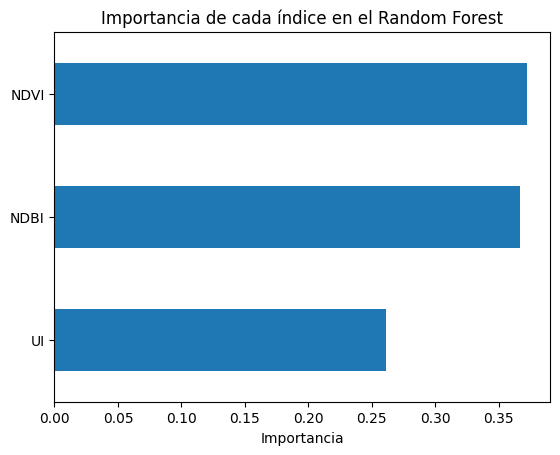

In [62]:
# 1) Extraer importancias del modelo
importances = clf.feature_importances_ # NDVI, NDBI, UI

# 2) Crear un Series para ordenarlas fácilmente
feat_imp = pd.Series(importances, index=['NDVI', 'NDBI', 'UI']).sort_values()

# 3) Dibujar un gráfico horizontal de barras
plt.figure()
feat_imp.plot.barh()
plt.xlabel("Importancia")
plt.title("Importancia de cada índice en el Random Forest")
plt.show()

## Análisis de importancias de los índices

El gráfico muestra la contribución relativa de cada índice (`NDVI`, `NDBI`, `UI`) al rendimiento del modelo Random Forest:

| Índice | Importancia aproximada |
|:------:|:----------------------:|
| **NDVI** | 0.38 |
| **NDBI** | 0.37 |
| **UI**   | 0.25 |

### Interpretación

1. **NDVI (≈ 38 %)**  
   - Es el índice más determinante para distinguir vegetación vs. no vegetación.  
   - Su alta importancia se alinea con la clara separación observada en los boxplots: valores elevados en vegetación y bajos en áreas urbanas.

2. **NDBI (≈ 37 %)**  
   - Muy cercano a NDVI en importancia, lo que indica que el contraste sociedad–suelo/vegetación también aporta casi tanto como el índice de vegetación.  
   - Su rol complementa al NDVI especialmente en zonas mixtas o con suelos expuestos donde NDVI pierde algo de discriminación.

3. **UI (≈ 25 %)**  
   - Contribuye menos que NDVI y NDBI, pero sigue siendo relevante (25 % del “peso” total).  
   - Probablemente capta matices urbanísticos (asfalto, hormigón) que no quedan del todo reflejados por NDVI/NDBI.

### Conclusiones y siguientes pasos

- La fuerte aportación de **NDVI** y **NDBI** confirma que los índices espectrales clásicos son eficaces para separar vegetación de zonas construidas.  
- El **UI**, aunque menos determinante, añade información exclusiva del entorno urbano; descartarlo totalmente podría reducir robustez en casos complejos.  
- **Posibles acciones**:
  - Mantener los tres índices para maximizar generalización.
  - Explorar nuevos índices o transformaciones de UI que potencien su aporte.

## Búsqueda de hiperparámetros con GridSearchCV

 **búsqueda exhaustiva** (“grid search”) sobre distintas combinaciones de parámetros del Random Forest, usando **validación cruzada** para evaluar cada configuración. Esto ayuda a optimizar el rendimiento del modelo y evitar configuraciones subóptimas.

In [63]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators':      [100, 200, 300],
    'max_depth':         [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)

# Ejecutar búsqueda
grid.fit(X_train, y_train)

# Mostrar resultados
print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

# Reemplazar clf por el mejor estimador
clf = grid.best_estimator_


Best params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Best CV score: 0.9939284693185071


In [64]:
y_pred = clf.predict(X_val)
print("Accuracy (con mejores params):", accuracy_score(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

Accuracy (con mejores params): 0.9798333333333333
[[2905   95]
 [  26 2974]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3000
           1       0.97      0.99      0.98      3000

    accuracy                           0.98      6000
   macro avg       0.98      0.98      0.98      6000
weighted avg       0.98      0.98      0.98      6000



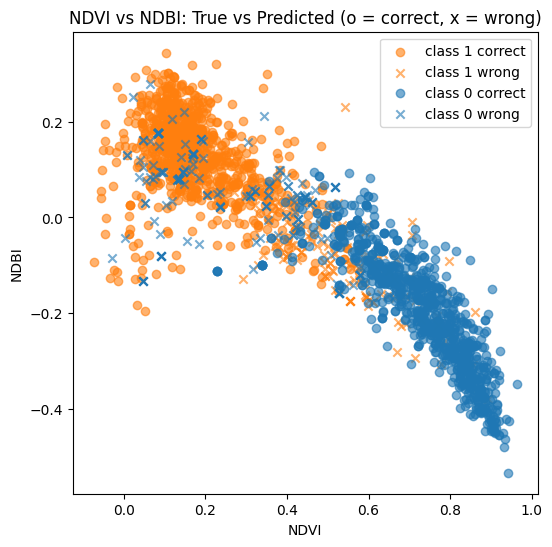

In [36]:
import matplotlib.pyplot as plt

# Prepare DataFrame with true labels and predictions
df_vis = df_val.copy()
df_vis['pred'] = y_pred

plt.figure(figsize=(6,6))

# Plot correct and incorrect points separately for each class
for lab in df_vis['label'].unique():
    sub = df_vis[df_vis['label'] == lab]
    correct = sub[sub['label'] == sub['pred']]
    wrong   = sub[sub['label'] != sub['pred']]
    
    # Correct predictions as circles
    plt.scatter(
        correct['NDVI'], correct['NDBI'],
        c='C0' if lab == 0 else 'C1',
        marker='o',
        label=f"class {lab} correct",
        alpha=0.6
    )
    # Incorrect predictions as crosses
    plt.scatter(
        wrong['NDVI'], wrong['NDBI'],
        c='C0' if lab == 0 else 'C1',
        marker='x',
        label=f"class {lab} wrong",
        alpha=0.6
    )

plt.xlabel('NDVI')
plt.ylabel('NDBI')
plt.title('NDVI vs NDBI: True vs Predicted (o = correct, x = wrong)')
plt.legend()
plt.show()



c:\Users\pipix\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


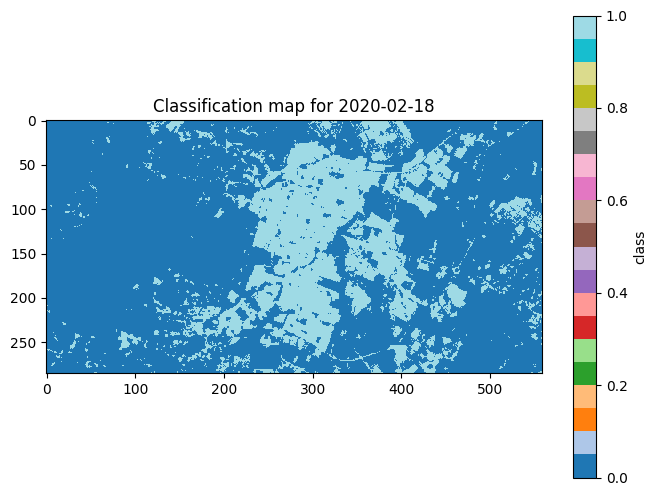

In [38]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# 1) Abre el raster de validación
raster_path = './carpeta_stacks/2020-02-18_stack3.tif'
with rasterio.open(raster_path) as src:
    # Lee las 3 bandas en un array (shape: 3, height, width)
    data = src.read([1,2,3]).astype('float32')
    # Reordena a (n_pixels, 3)
    h, w = data.shape[1:]
    flat = data.reshape(3, -1).T

# 2) Predice cada píxel
pred_flat = clf.predict(flat)

# 3) Reconstruye la imagen de predicción
pred_map = pred_flat.reshape(h, w)

# 4) Muestra el mapa
plt.figure(figsize=(8,6))
plt.imshow(pred_map, cmap='tab20', interpolation='nearest')
plt.title('Classification map for 2020-02-18')
plt.colorbar(label='class')
plt.show()


c:\Users\pipix\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\pipix\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


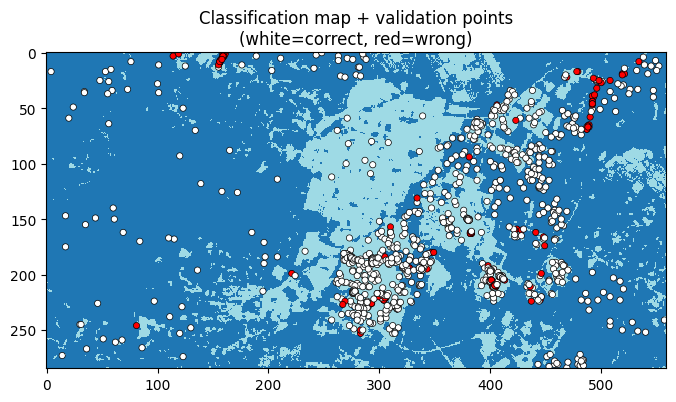

In [41]:
from rasterio.transform import rowcol

# 1) Open the validation raster
raster_path = './carpeta_stacks/2020-02-18_stack3.tif'
with rasterio.open(raster_path) as src:
    # read the three bands and flatten for prediction
    data = src.read([1,2,3]).astype('float32')
    h, w = data.shape[1:]
    flat = data.reshape(3, -1).T
    pred_flat = clf.predict(flat)
    pred_map = pred_flat.reshape(h, w)

    # 2) Load validation points for that date
    gval = gpd.read_file(gpkg_path, layer='points_training')
    gval = gval[gval['date'] == '2020-02-18']

    # 3) Compute row, col for each point
    xs = gval.geometry.x.tolist()
    ys = gval.geometry.y.tolist()
    rows, cols = rowcol(src.transform, xs, ys)

# 4) Plot
plt.figure(figsize=(8,6))
plt.imshow(pred_map, cmap='tab20', interpolation='nearest')
# White for correct, red for wrong
colors = ['white' if lab==pred else 'red'
          for lab, pred in zip(gval['label'], clf.predict(
              np.vstack([data[0, rows, cols],
                         data[1, rows, cols],
                         data[2, rows, cols]]).T))]
plt.scatter(cols, rows, s=20, c=colors, edgecolor='black', linewidth=0.5)
plt.title('Classification map + validation points\n(white=correct, red=wrong)')
plt.show()
